### Preprocessing 
1.) Original image shape (1024 * 1024) 
    Resize Image to (224 * 224) 

2.) Standardize the pixel values intos the interval [0,1] by scaling with 1/255 . 

3.) Split dataset into 24000 train images and 2648 validation images 

4.) Store converted images in folders corresponding to the class 
   1.) 0 if no pneumonia <br> 
   2.) 1 if pneumonia<br> 

# Dataset 
1.) Make use of torchvision.DatasetFolder 
    No need for custom dataset classes 

2.) Z-normalize images with computed mean and std 

3.) Apply Data Augmentation:  <br> 
   1.) Random Rotations <br> 
   2.) Random Translations <br> 
   3.) Random Scales <br> 
   4.) Random Resized Crops<br> 

In [3]:
from pathlib import Path 
import pydicom 
import numpy as np 
import cv2
import pandas as pd 
import matplotlib.pyplot as plt 
from tqdm.notebook import tqdm 


In [4]:
labels = pd.read_csv('Documents/rsna-pneumonia-detection-challenge/stage_2_train_labels.csv')


                     

In [5]:
labels.head()

,patientId,x,y,width,height,Target
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1


In [6]:
labels = labels.drop_duplicates('patientId')

In [7]:
ROOT_PATH = Path('Documents/rsna-pneumonia-detection-challenge/stage_2_train_images')  
SAVE_PATH = Path("Processed")



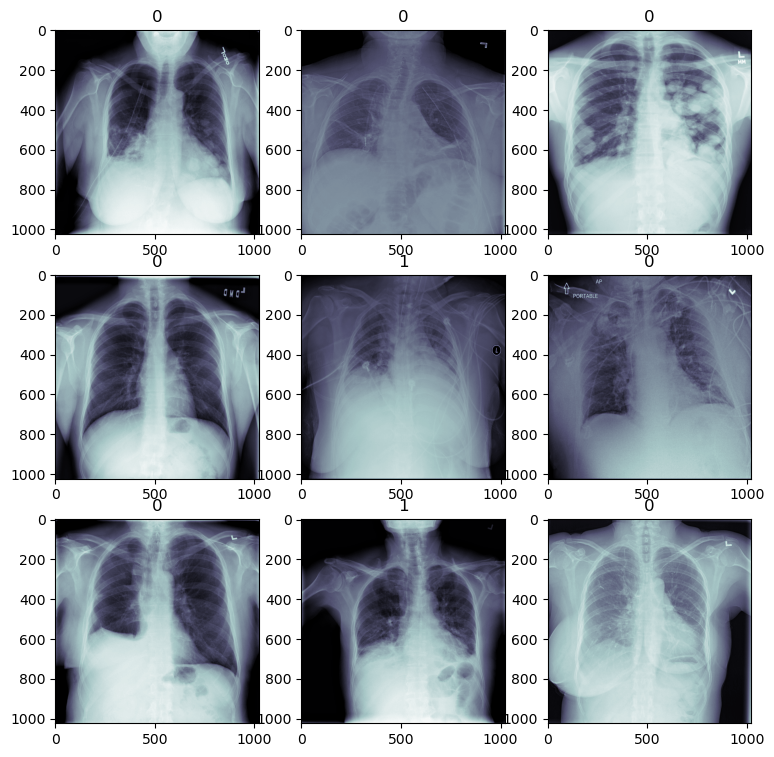

In [8]:
fig, axis = plt.subplots(3, 3, figsize=(9, 9)) 

c = 0 
for i in range(3): 
    for j in range(3): 
        patient_id = labels.patientId.iloc[c] 
        dcm_path = ROOT_PATH/patient_id 
        dcm_path = dcm_path.with_suffix(".dcm") 
        dcm = pydicom .dcmread(dcm_path).pixel_array 

        label = labels['Target'].iloc[c] 
        axis[i][j].imshow(dcm, cmap="bone") 
        axis[i][j].set_title(label) 
        c+=1 
        


In [9]:
sums, sums_squared = 0, 0 

for c, patient_id in enumerate(tqdm(labels.patientId)):
    patient_id = labels.patientId.iloc[c]  
    dcm_path = ROOT_PATH/patient_id 
    dcm_path = dcm_path.with_suffix(".dcm") 
    dcm = pydicom.dcmread(dcm_path).pixel_array / 255 

    dcm_array = cv2.resize(dcm, (224, 224)).astype(np.float16) 
    label = labels.Target.iloc[c] 

    train_or_val = "train" if c < 24000 else "val" 

    current_save_path = SAVE_PATH/train_or_val/str(label) 
    current_save_path.mkdir(parents=True, exist_ok=True) 
    np.save(current_save_path/patient_id, dcm_array) 

    normalizer = 224*224 
    if train_or_val == "train":
         sums += np.sum(dcm_array) / normalizer 
         sums_squared += (dcm_array ** 2).sum() / normalizer 



  0%|          | 0/26684 [00:00<?, ?it/s]

In [10]:
mean = sums/24000 
std = np.sqrt((sums_squared / 24000) - mean**2) 


In [11]:
mean, std

(0.49039623525191567, 0.2479507326197431)

# Data Loading

In [13]:
import torch 
import torchvision 
from torchvision import transforms 
import torchmetrics 
from pytorch_lightning.callbacks import ModelCheckpoint 
from pytorch_lightning.loggers import TensorBoardLogger 
from tqdm.notebook import tqdm 
import numpy as np 
import matplotlib.pyplot as plt 


In [14]:
import torch
import torchvision
from torchvision import transforms
import torchmetrics
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.loggers import TensorBoardLogger
from tqdm.notebook import tqdm
import numpy as np
import matplotlib.pyplot as plt 
from lightning.pytorch.callbacks.early_stopping import EarlyStopping


In [15]:
conda install lightning -c conda-forge

Channels:
 - conda-forge
 - defaults
 - pytorch
Platform: osx-arm64
Solving environment: done

# All requested packages already installed.


Note: you may need to restart the kernel to use updated packages.


In [16]:
pip install torchmetrics

Note: you may need to restart the kernel to use updated packages.


In [17]:
pip install pytorch-lightning

Note: you may need to restart the kernel to use updated packages.


In [18]:
def load_file(path):
    return np.load(path).astype(np.float32) 


In [19]:
train_transforms = transforms.Compose([
                            transforms.ToTensor(), 
                            transforms.Normalize(0.49, 0.248), 
                            transforms.RandomAffine(degrees=(-5,5), translate=(0,0.05), scale=(0.9, 1.1)), 
                            transforms.RandomResizedCrop((224,224), scale=(0.35, 1))  

]) 

val_transforms = transforms.Compose([ 
                            transforms.ToTensor(),
                            transforms.Normalize(0.49, 0.248), 
]) 

In [20]:
train_dataset = torchvision.datasets.DatasetFolder(
    "Processed/train/",
    loader=load_file, extensions="npy", transform=train_transforms)

val_dataset = torchvision.datasets.DatasetFolder(
    "Processed/val/",
    loader=load_file, extensions="npy", transform=val_transforms)




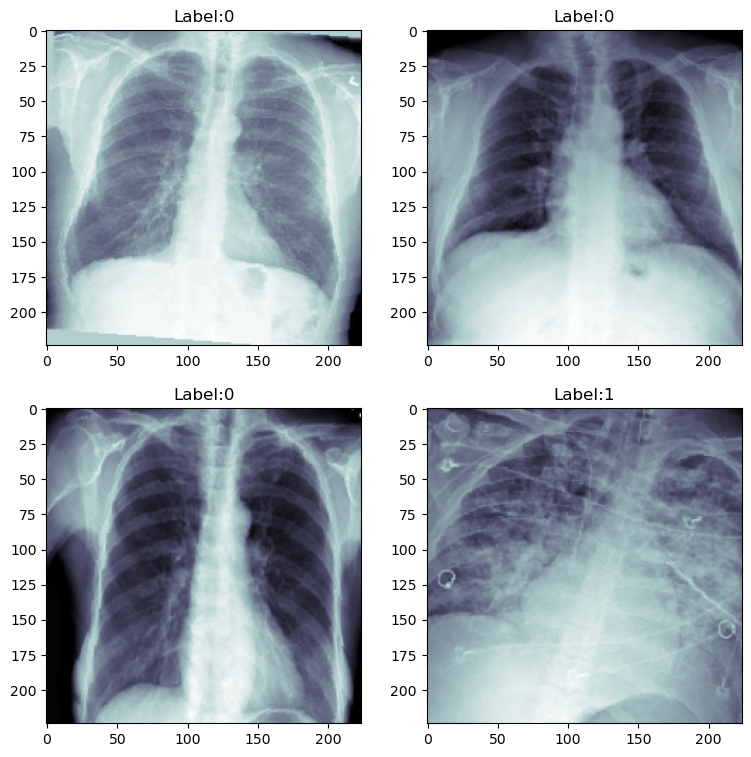

In [21]:
fig, axis = plt.subplots(2, 2, figsize=(9, 9))
for i in range(2):
    for j in range(2):
        random_index = np.random.randint(0, 20000)
        x_ray, label = train_dataset[random_index]
        axis[i][j].imshow(x_ray[0], cmap="bone")
        axis[i][j].set_title(f"Label:{label}")


In [22]:
batch_size = 64 #TODO
num_workers = 0 # TODO

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=False)

print(f"There are {len(train_dataset)} train images and {len(val_dataset)} val images")

There are 24000 train images and 2684 val images


The classes are imbalanced: There are more images without signs of pneumonia than with pneumonia.
There are multiple ways to deal with imbalanced datasets:
* Weighted Loss
* Oversampling
* Doing nothing :)

In this example, we will simply do nothing as this often yields the best results.
Buf feel free to play around with a weighted loss. A template to define a customized weighted loss function is provided below.

Oversampling will be shown in a later lecture.

In [24]:
np.unique(train_dataset.targets, return_counts=True)

(array([0, 1]), array([18593,  5407]))

## Model Creation in pytorch lightning

Each pytorch lightning model is defined by at least an initialization method, a **forward** function which defines the forward pass/prediction, a **training_step** which yields the loss and **configure_optimizers** to specify the optimization algorithm.

Additionally, we can use a **training_epoch_end** callback to compute overall dataset statistics and metrics such as accuracy.

Subsequently, we define the **validation_step**. The validation step performs more or less the same steps as the training step, however, on the validation data. In this case, pytorch lightning doesn't update the weights.
Again, we can use **validation_epoch_end** to compute overall dataset metrics.

No loops or manual weight updates are needed!<br />
Additionally, pl also handles device management.  Just pass the number of GPUS when creating the trainer.

**Now it is time to create the model** - We will use the ResNet18 network architecture.

As most of the torchvision models, the original ResNet expects a three channel input in **conv1**. <br />
However, our X-Ray image data has only one channel.
Thus we need to change the in_channel parameter from 3 to 1.

Additionally, we will change the last fully connected layer to have only one output as we have a binary class label.

### Optimizer and Loss
We use the **Adam** Optimizer with a learning rate of 0.0001 and the **BinaryCrossEntropy** Loss function.<br />
(In fact we use **BCEWithLogitsLoss** which directly accepts the raw unprocessed predicted values and computes the sigmoid activation function before applying Cross Entropy).
Feel free to pass a weight different from 1 to the Pneumonia model in order to use the weighted loss function.


In [28]:
class PneumoniaModel(pl.LightningModule):
    def __init__(self, weight=1):
        super().__init__()
        
        self.model = torchvision.models.resnet18()
        # change conv1 from 3 to 1 input channels
        self.model.conv1 = torch.nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        # change out_feature of the last fully connected layer (called fc in resnet18) from 1000 to 1
        self.model.fc = torch.nn.Linear(in_features=512, out_features=1, bias=True)
        
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=1e-4)
        self.loss_fn = torch.nn.BCEWithLogitsLoss(pos_weight=torch.tensor([3]))
        
        # simple accuracy computation
        self.train_acc = torchmetrics.Accuracy(task='binary')
        self.val_acc = torchmetrics.Accuracy(task='binary')

    def forward(self, data):
        pred = self.model(data)
        return pred
    
    def training_step(self, batch, batch_idx):
        x_ray, label = batch
        label = label.float()  # Convert label to float (just needed for loss computation)
        pred = self(x_ray)[:,0]  # Prediction: Make sure prediction and label have same shape
        loss = self.loss_fn(pred, label)  # Compute the loss
        
        # Log loss and batch accuracy
        self.log("Train Loss", loss)
        self.log("Step Train Acc", self.train_acc(torch.sigmoid(pred), label.int()))
        return loss
    
    
    def on_training_epoch_end(self, outs):
        # After one epoch compute the whole train_data accuracy
        self.log("Train Acc", self.train_acc.compute())
        
        
    def validation_step(self, batch, batch_idx):
        # Same steps as in the training_step
        x_ray, label = batch
        label = label.float()
        pred = self(x_ray)[:,0]  # make sure prediction and label have same shape

        loss = self.loss_fn(pred, label)
        
        # Log validation metrics
        self.log("Val Loss", loss, prog_bar=True)
        self.log("Val Acc", self.val_acc(torch.sigmoid(pred), label.int()))
        return loss
    
    # def validation_epoch_end(self, outs):
    #     self.log("Val Acc", self.val_acc.compute())
    
    def configure_optimizers(self):
        #Caution! You always need to return a list here (just pack your optimizer into one :))
        return [self.optimizer] 

In [29]:
torchvision.models.resnet18()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [30]:
model = PneumoniaModel()  # Instanciate the model

In [31]:
model

PneumoniaModel(
  (model): ResNet(
    (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, trac

We create a checkpoint callback which only stores the 10 best models based on the validation accuracy.

In [33]:
# Create the checkpoint callback
checkpoint_callback = ModelCheckpoint(
    monitor='Val Acc',
    save_top_k=10,
    mode='max')

In [34]:
# checkpoint_callback = ModelCheckpoint(
#    dirpath="checkpoints",
#    monitor="val_loss",
#    filename="cifar10-{epoch:02d}-{val_loss:.2f}-{val_acc:.2f}",
#    save_top_k=3,
#    mode="min",
# )

In [35]:
early_stopping = EarlyStopping(monitor="val_loss", patience=5, mode="min", verbose=False)



In [36]:


trainer = pl.Trainer(accelerator="gpu" if torch.cuda.is_available() else "cpu",
                     devices="auto",
                     logger=TensorBoardLogger(save_dir="./logs"), log_every_n_steps=1,
                     callbacks=checkpoint_callback,
                     max_epochs=5)

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/opt/homebrew/anaconda3/lib/python3.12/site-packages/pytorch_lightning/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.


In [37]:
# Create the trainer
# Change the gpus parameter to the number of available gpus on your system. Use 0 for CPU training


# trainer = pl.Trainer(accelerator="gpu" if torch.cuda.is_available() else "cpu",
#                      devices="auto", logger=TensorBoardLogger("./logs"), log_every_n_steps=1,
#                      # callbacks=[checkpoint_callback, early_stopping],
#                      default_root_dir="./weights", 
#                      callbacks=checkpoint_callback,
#                      max_epochs=20)



In [38]:
!pip install -U tensorboardX 


In [39]:
pip install -U tensorboard

Note: you may need to restart the kernel to use updated packages.


In [40]:
%load_ext tensorboard


In [41]:
%reload_ext tensorboard

In [42]:
# Train the detection model
trainer.fit(model, train_loader, val_loader)




  | Name      | Type              | Params | Mode 
--------------------------------------------------------
0 | model     | ResNet            | 11.2 M | train
1 | loss_fn   | BCEWithLogitsLoss | 0      | train
2 | train_acc | BinaryAccuracy    | 0      | train
3 | val_acc   | BinaryAccuracy    | 0      | train
--------------------------------------------------------
11.2 M    Trainable params
0         Non-trainable params
11.2 M    Total params
44.683    Total estimated model params size (MB)
71        Modules in train mode
0         Modules in eval mode


Sanity Checking: |                                        | 0/? [00:00<?, ?it/s]

/opt/homebrew/anaconda3/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/anaconda3/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Training: |                                               | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=5` reached.
